# Chapter 20: Scale Up Double Deep Q Learning

You'll learn to scale up the double deep Q network to play any Atari game. To make this point clear, you'll define a function that trains any Atari games with the same deep Q network. All you need is to put in the name of the game as the only argument in the function. 

Once the function is defined, you'll test it on two Atari games: Seaquest and Beam Rider. You'll see that the defined function can train the two games successfully by just taking one piece of information: the name of the game. 

Even though the agent does not know the rules of the Seaquest or Beam Rider game, it manages to have perfect scores, just by learning from repeated interactions with the game environment and the rewards it receives as a result.  

This shows that machine learning models are highly scalable. This can potentially have large implications for artificial intelligence (AI): it means we can turn narrow AI into general AI by scaling up the model and by applying it to different situations.  

At the end of the chapter, you'll capture an episode of the Seaquest game and an episode of the Beam Rider game. You'll put them side by side in an animation so that you can see the trained model in action, like so: 
<img src="https://gattonweb.uky.edu/faculty/lium/ml/Seaquest_BeamRider.gif" />

***
$\mathbf{\text{Create a subfolder for files in Chapter 20}}$<br>
***
We'll put all files in Chapter 20 in a subfolder /files/ch20. The code in the cell below will create the subfolder.

***

In [1]:
import os

os.makedirs("files/ch20", exist_ok=True)

## 1. Get Started with the Seaquest Game

In this section, you'll learn how to play the Seaquest game, both with and without the help from the baselines package.

### 1.1. The Seaquest Game in OpenAI Gym

You'll first learn to play the Seaquest game in OpenAI Gym.

These lines of code will get you started.

In [33]:
import gym
env = gym.make("Seaquest-v0")
env.reset()
env.render()

True

You should see a Seaquest game frame in a separate window. 

You can check the action space and observation space of the game as follows:

In [34]:
# Print out all possible actions in this game
actions = env.action_space
print(f"The action space for the Seaquest game is {actions}")
meanings = env.env.get_action_meanings()
print(f"The meanings of the actions for the Seaquest game are\n {meanings}")

# Print out the observation space in this game
obs_space = env.observation_space
print(f"The observation space for the Seaquest game is {obs_space}")

The action space for the Seaquest game is Discrete(18)
The meanings of the actions for the Seaquest game are
 ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']
The observation space for the Seaquest game is Box(210, 160, 3)


There are 18 possible actions the agent can take. However, the agent doesn't even need to understand the game to learn to play it. All we need is the right reward system. So I won't disucss the meanings of all the possible actions. 

Each observation is a color picture that is 210 pixels tall and 160 pixels wide. The same as any other Atari game. The following cell displays an observation.

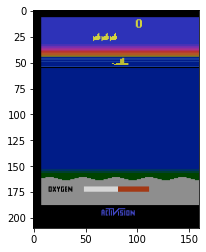

In [35]:
import matplotlib.pyplot as plt
import numpy as np

num_actions = env.action_space.n

env.reset()
for _ in range(20):
    action = np.random.choice(num_actions)
    obs, reward, done, info = env.step(action)
plt.imshow(obs)
plt.show()
env.close()

Next, you'll print out the outputs of the game to understand the reward system.

In [36]:
import gym
from pprint import pprint
env = gym.make("Seaquest-v0")
env.reset()
env.render()

history = []
while True:
    action = np.random.choice(num_actions)
    obs, reward, done, info = env.step(action)
    env.render()
    history.append([reward, done, info])
    if len(history)>1:
        if info["ale.lives"]<history[-2][2]["ale.lives"]:
            pprint(history[-10:])
            break
env.close()        

[[0.0, False, {'ale.lives': 4}],
 [0.0, False, {'ale.lives': 4}],
 [0.0, False, {'ale.lives': 4}],
 [0.0, False, {'ale.lives': 4}],
 [0.0, False, {'ale.lives': 4}],
 [0.0, False, {'ale.lives': 4}],
 [0.0, False, {'ale.lives': 4}],
 [0.0, False, {'ale.lives': 4}],
 [0.0, False, {'ale.lives': 4}],
 [0.0, False, {'ale.lives': 3}]]


The agent has four lives in this game. When one life is lost, the reward is still 0, not -1 as in the Pong game. Further, the variable *done* is still False after a life is lost. The variable *done* turns True only after all lives are lost.

Therefore, we need the help of the baselines package to break an episode into smaller episodes. 

### 1.2. The Seaquest Game with OpenAI Baselines

With the baselines game wrapper, the agent has one life in each episode. That is, each time the agent loses a life, the episode ends and the variable *done* turns True. This makes reconfiguring the reward system much easier. Each time the game ends (i.e., done==True), we set the Q-value to -1. This is crucial for the success of the training. 

Let's make sure that's indeed the case. Run the code in the cell below.

In [37]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind

# Use the Baseline Atari environment
env = make_atari("SeaquestNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)

obs = env.reset()
history = []
while True:
    # randomly pick actions
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    history.append([action, reward, done, info])
    # Render the env
    env.render()
    if done:
        pprint(history[-10:])
        break
env.close()        

[[11, 0.0, False, {'ale.lives': 4}],
 [15, 0.0, False, {'ale.lives': 4}],
 [17, 0.0, False, {'ale.lives': 4}],
 [9, 0.0, False, {'ale.lives': 4}],
 [15, 0.0, False, {'ale.lives': 4}],
 [16, 0.0, False, {'ale.lives': 4}],
 [9, 0.0, False, {'ale.lives': 4}],
 [7, 0.0, False, {'ale.lives': 4}],
 [12, 0.0, False, {'ale.lives': 4}],
 [4, 0.0, True, {'ale.lives': 3}]]


As you can see, when the number of lives changes from 3 to 2, the variable done becomes True and the episode ends. Note that the reward is 4, not -1, when a life is lost. But we can code it as -1 by using this line of code; you'll see it in the script for training later:

```python
    # Each time the agent loses a life, set Q to -1; important
    new_Qs = Qs * (1 - dones) - dones
```

### 1.3. Preprocessed Frames from OpenAI Baselines

The baselines game wrapper preprocesses the game images for you. In every time step, it returns four consecutive frames of preprocessed images, each with a size of 84 by 84.  

Let's visualize the preprocessed images from the baseline package. Run the code in the cell below.

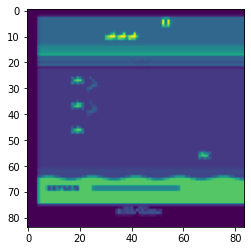

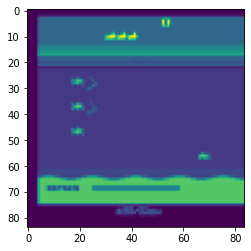

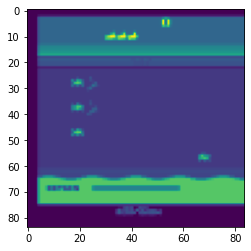

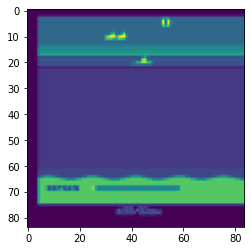

In [38]:
import matplotlib.pyplot as plt
import numpy as np

npobs=np.array(obs)
for i in range(4):
    plt.imshow(npobs[:,:,i])
    plt.show()

You can see that the four pictures are different from each other. The agent can detect movements from these frames during the training process.

## 2. Get Started with the Beam Rider Game

In this section, you'll learn how to play another Atari game, the Beam Rider game, both with and without the help from the baselines package.

### 2.1. The Beam Rider Game in OpenAI Gym

You'll first learn to play the Beam Rider game in OpenAI Gym.

The cell below will get you started.

In [1]:
import gym
env = gym.make("BeamRider-v0")
env.reset()
env.render()

True

You should see a Beam Rider game frame in a separate window. 

You can check the action space and observation space of the game as follows:

In [2]:
# Print out all possible actions in this game
actions = env.action_space
print(f"The action space for the Beam Rider game is {actions}")

meanings = env.env.get_action_meanings()
print(f"The meanings of the actions for the Beam Rider game are\n {meanings}")

# Print out the observation space in this game
obs_space = env.observation_space
print(f"The observation space for the Beam Rider game is {obs_space}")

The action space for the Beam Rider game is Discrete(9)
The meanings of the actions for the Beam Rider game are
 ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'UPRIGHT', 'UPLEFT', 'RIGHTFIRE', 'LEFTFIRE']
The observation space for the Beam Rider game is Box(210, 160, 3)


There are 9 possible actions the agent can take. However, the agent doesn't even need to understand the game to learn to play it. All we need is the right reward system. So I won't disucss all the possible actions. 

Each observation is a color picture of size 210 by 160 by 3. The same as any other Atari game. The following cell displays an observation.

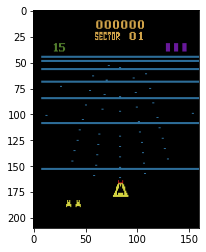

In [3]:
import matplotlib.pyplot as plt
import numpy as np

num_actions = env.action_space.n

env.reset()
for _ in range(20):
    action = np.random.choice(num_actions)
    obs, reward, done, info = env.step(action)
plt.imshow(obs)
plt.show()
env.close()

Next, you'll print out the outputs of the game to understand the reward system.

In [5]:
import gym
from pprint import pprint
env = gym.make("BeamRider-v0")
env.reset()
env.render()

history = []
while True:
    action = np.random.choice(num_actions)
    obs, reward, done, info = env.step(action)
    env.render()
    history.append([reward, done, info])
    if len(history)>1:
        if info["ale.lives"]<history[-2][2]["ale.lives"]:
            pprint(history[-10:])
            break
env.close()        

[[0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 2}]]


The agent has three lives in this game. When one life is lost, the reward is still 0, not -1 as in the Pong game. Further, the variable *done* is still False after a life is lost. The variable *done* turns True only after all lives are lost.

Therefore, we need the help of the baselines package to break an episode into smaller episodes. 

### 2.2. The Beam Rider Game with OpenAI Baselines

With the baselines game wrapper, the agent has one life in each episode. That is, each time the agent loses a life, the episode ends and the variable *done* turns True. This makes reconfiguring the reward system much easier. Each time the game ends (i.e., done==True), we set the Q-value to -1. This is crucial for the success of the training. 

Let's make sure that's indeed the case. Run the code in the cell below.

In [44]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind

# Use the Baseline Atari environment
env = make_atari("BeamRiderNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)

obs = env.reset()
history = []
while True:
    # randomly pick actions
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    history.append([action, reward, done, info])
    # Render the env
    env.render()
    if done:
        pprint(history[-10:])
        break
env.close()        

[[1, 0.0, False, {'ale.lives': 3}],
 [7, 0.0, False, {'ale.lives': 3}],
 [7, 0.0, False, {'ale.lives': 3}],
 [7, 0.0, False, {'ale.lives': 3}],
 [0, 0.0, False, {'ale.lives': 3}],
 [8, 0.0, False, {'ale.lives': 3}],
 [5, 0.0, False, {'ale.lives': 3}],
 [5, 0.0, False, {'ale.lives': 3}],
 [8, 0.0, False, {'ale.lives': 3}],
 [7, 0.0, True, {'ale.lives': 2}]]


As you can see, when the number of lives changes from 3 to 2, the variable done becomes True and the episode ends. Note that the reward is 7, not -1, but we can code it as -1 by using this line of code; you'll see it in the script for training later:

```python
    # Each time the agent loses a life, set Q to -1; important
    new_Qs = Qs * (1 - dones) - dones
```

### 2.3. Preprocessed Frames from OpenAI Baselines

The baselines game wrapper preprocesses the game images for you. In every time step, it returns four consecutive frames of preprocessed images, each with a size of 84 by 84.  

Let's visualize the preprocessed images from the baseline package. Run the code in the cell below.

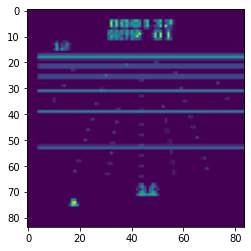

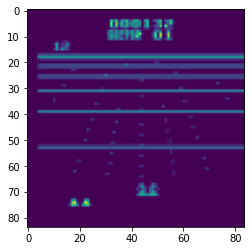

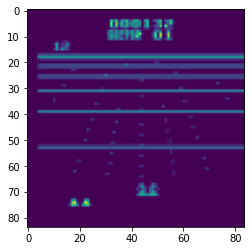

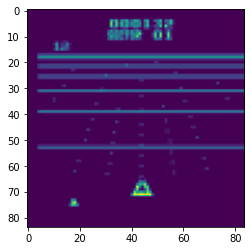

In [45]:
import matplotlib.pyplot as plt
import numpy as np

npobs=np.array(obs)
for i in range(4):
    plt.imshow(npobs[:,:,i])
    plt.show()

You can see the four consecutive frames. The four images look slighly different from each other.

## 3. Scale Up the Double Deep Q Network
Next, we'll scale up the double deep Q network to train any Atari game. Specifically, we'll define a function to train all games, and the only argument needed is the name of the game. 

### 3.1. Differences Among Atari Games

What are the differences among Atari games? 

#### Game environment

Obviously, the names of the games are different. But there is a pattern. For the four games Breakout, Space Invaders, Seaquest, and Beam Rider, their environment names are:
* BreakoutNoFrameskip-v4
* SpaceInvadersNoFrameskip-v4
* SeaquestNoFrameskip-v4
* BeamRiderNoFrameskip-v4
respectively. Therefore we can use 

```python
f"{name}NoFrameskip-v4"
```

to scale up the game environment. 

#### The number of actions

The number of actions are different in different games. For the four games Breakout, Space Invaders, Seaquest, and Beam Rider, the numbers of actions are 4, 6, 18, and 9, respectively. However, we can use the code:

```python
num_actions = env.action_space.n
```

to retrieve the number of actions for each game.  

We can leave everyting else in the training program the same.

### 3.2. Define A Function to Train All Atari Games

Next, we define a function to train all Atari games. 

In [46]:
# Define the train_atari() function
def train_atari(name):
    import random
    from collections import deque
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras import layers
    from baselines.common.atari_wrappers import make_atari
    from baselines.common.atari_wrappers import wrap_deepmind

    # Use the Baseline Atari environment
    env = make_atari(f"{name}NoFrameskip-v4")
    # Process and stack the frames
    env = wrap_deepmind(env, frame_stack=True, scale=True)

    # Discount factor for past rewards
    gamma = 0.99 
    # batch size
    batch_size = 32  

    # The number of actions 
    num_actions = env.action_space.n

    # The same double Q deep neural network, applies to all Atari games
    def create_model():
        # Network defined by the Deepmind paper
        inputs = layers.Input(shape=(84, 84, 4,))
        # Convolutions on the frames on the screen
        layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
        layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
        layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
        layer4 = layers.Flatten()(layer3)
        layer5 = layers.Dense(512, activation="relu")(layer4)
        action = layers.Dense(num_actions, activation="linear")(layer5)
        return tf.keras.Model(inputs=inputs, outputs=action)

    # Double Deep Q Learning here
    # The model predicts Q-values, to determine action 
    dnn = create_model()
    # Target model predicts future rewards
    # The weights of a target model are updated every 10000 frames thus when the
    # loss between the Q-values is calculated the target Q-value is stable.
    target_dnn = create_model()

    # Optimizer and loss function
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
    loss_function = tf.keras.losses.Huber()

    # See how many trainable parameters in the deep neural network
    print(dnn.summary())

    # Create a replay buffer with a maximum length of 50000
    # If you don't have enough memory on your computer, change it to 20000
    memory=deque(maxlen=50000)
    # Create a running rewards list with a length of 100
    running_rewards=deque(maxlen=100)

    # Replay and update model parameters
    def replay():
        # select a batch from the buffer memory
        samples = random.sample(memory,batch_size)
        dones = []
        frames = []
        new_frames = []
        rewards = []
        actions = []
        for sample in samples:
            frame, new_frame, action, reward, done = sample
            frames.append(frame)
            new_frames.append(new_frame)
            actions.append(action)
            dones.append(done)
            rewards.append(reward)
        frames=np.array(frames)
        new_frames=np.array(new_frames)
        dones=tf.convert_to_tensor(dones)

        # update the Q table
        preds = target_dnn.predict(new_frames, verbose=0)
        Qs = rewards + gamma * tf.reduce_max(preds, axis=1)
        # Each time the agent loses a life, set Q to -1; important
        new_Qs = Qs * (1 - dones) - dones

        # update model parameters
        onehot = tf.one_hot(actions, num_actions)
        with tf.GradientTape() as t:
            Q_preds = dnn(frames)
            # Calculate old Qs for the action taken
            old_Qs = tf.reduce_sum(tf.multiply(Q_preds, onehot),axis=1)
            # Calculate loss between new Qs and old Qs
            loss = loss_function(new_Qs, old_Qs)
        # Update using backpropagation
        gs = t.gradient(loss,dnn.trainable_variables)
        optimizer.apply_gradients(zip(gs,dnn.trainable_variables))

    # Let the game begin
    running_reward = 0
    frame_count = 0
    # Number of frames to take random action and observe output
    epsilon_random_frames = 50000

    # Train the model after 4 actions
    update_after_actions = 4
    # How often to update the target network
    update_target_network = 10000

    for episode in range(1, 100000): 
        # reset state and episode reward before each episode
        state = np.array(env.reset())
        episode_reward = 0

        # Allow 10,000 steps per episode
        for timestep in range(1, 10001):
            frame_count += 1
            # Calculate current epsilon based on frame count
            epsilon = max(0.1, 1 - frame_count * (1-0.1) /1000000)
            # Use epsilon-greedy for exploration
            if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
                # Take random action
                action = np.random.choice(num_actions)
            # Use exploitation
            else:
                # Predict action Q-values
                # From environment state
                state_tensor = tf.convert_to_tensor(state)
                state_tensor = tf.expand_dims(state_tensor, 0)
                action_probs = dnn(state_tensor, training=False)
                # Take best action
                action = tf.argmax(action_probs[0]).numpy()

            # Apply the sampled action in our environment
            state_next, reward, done, _ = env.step(action)
            state_next = np.array(state_next)
            episode_reward += reward
            # Change done from True/False to 1.0 or 0.0 to prevent error
            if done==True:
                done=1.0
            else:
                done=0.0
            # Save actions and states in replay buffer
            memory.append([state, state_next, action, reward, done])
            # current state becomes the next state in next round
            state = state_next

            # Update every fourth frame and once batch size is over 32
            if frame_count % update_after_actions == 0 and \
                len(memory) > batch_size:
                replay()

            if frame_count % update_target_network == 0:
                # update the the target network with new weights
                target_dnn.set_weights(dnn.get_weights())
                running_reward = np.mean(np.array(running_rewards))
                # Log details
                template="running reward: {:.2f} episode {}, frame count {}"
                print(template.format(running_reward, episode, frame_count))
                # Periodically save the model
                dnn.save(f"files/ch20/DoubleQ_{name}.h5")
            if done==1.0:
                running_rewards.append(episode_reward)
                break
        # Condition to consider the task solved
        if running_reward > 20:  
            print(f"Solved at episode {episode}!")
            # save the final model
            dnn.save("files/ch20/DoubleQ_{name}_final.h5")        
            break

We are now ready to use this function to train any Atari game. 

## 4. Try It on Seaquest
Next, you'll apply the scaled up double deep Q network on the Seaquest game. You'll use the function *train_atari()* we defined in the last section to train the agent. After that, you'll test how effective the pre-trained model is. 

### 4.1. Train the Model
The following line of code will train the agent in the Seaquest game.

In [ ]:
train_atari("Seaquest")

The training takes a couple of days. But you can use a pre-trained model that I put on GitHub, saved as files/ch20/Seaquest.h5.

### 4.2. Test One Original Episode
The original Atari Seaquest game has 4 lives in each episode. But the baseline package breaks it down to 4 smaller episodes. 

Here you'll play the game four consecutive episodes with the baseline package so that you'll have one full original episode. 

You'll turn on the graphical rendering of the game frames so that you can visualize the game in action.

In [7]:
import numpy as np
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import tensorflow as tf

reload = tf.keras.models.load_model("files/ch20/Seaquest.h5")

# Use the Baseline Atari environment
env = make_atari("SeaquestNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)
num_actions = env.action_space.n

for i in range(4):
    score = 0
    state = env.reset()
    for j in range(10000):
        if np.random.rand(1)[0]<0.01:
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = reload(state_tensor, training=False)
            # Take the best action
            action = tf.argmax(action_probs[0]).numpy()    
        obs, reward, done, info = env.step(action)
        score += reward
        env.render()
        state=obs
        if done:
            print("the score is", score)
            break

env.close()

the score is 30.0
the score is 30.0
the score is 25.0
the score is 29.0


As you can see, the trained model is able to have high scores. It earned between 25 and 30 points in each episode.  

### 4.3. Play Multiple Games and Test the Average Score

We now play 40 games and turn off the graphical rendering. We'll see what the average score is.  

In [50]:
import numpy as np
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import tensorflow as tf

reload = tf.keras.models.load_model("files/ch20/Seaquest.h5")

# Use the Baseline Atari environment
env = make_atari("SeaquestNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)
scores = []
num_actions = env.action_space.n
for i in range(40):
    state = env.reset()
    score = 0
    for j in range(10000):
        if np.random.rand(1)[0]<0.01:
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = reload(state_tensor, training=False)
            # Take the best action
            action = tf.argmax(action_probs[0]).numpy()    
        obs, reward, done, info = env.step(action)
        #env.render()
        state=obs
        score += reward
        if done:
            print(f"the score in episode {i+1} is {score}")
            scores.append(score)
            break
env.close()

print(f"the average score is {np.array(scores).mean()}")

the score in episode 1 is 3.0
the score in episode 2 is 29.0
the score in episode 3 is 28.0
the score in episode 4 is 30.0
the score in episode 5 is 28.0
the score in episode 6 is 28.0
the score in episode 7 is 29.0
the score in episode 8 is 26.0
the score in episode 9 is 30.0
the score in episode 10 is 30.0
the score in episode 11 is 27.0
the score in episode 12 is 30.0
the score in episode 13 is 30.0
the score in episode 14 is 28.0
the score in episode 15 is 29.0
the score in episode 16 is 28.0
the score in episode 17 is 30.0
the score in episode 18 is 27.0
the score in episode 19 is 29.0
the score in episode 20 is 27.0
the score in episode 21 is 28.0
the score in episode 22 is 22.0
the score in episode 23 is 30.0
the score in episode 24 is 26.0
the score in episode 25 is 3.0
the score in episode 26 is 28.0
the score in episode 27 is 30.0
the score in episode 28 is 30.0
the score in episode 29 is 30.0
the score in episode 30 is 26.0
the score in episode 31 is 27.0
the score in episod

The average score is about 25 per episode.

### 4.4. Animate Successful Episodes
We'll highlight episodes where the agent performs well.

We'll first record 20 episodes, and this is equivalent to five full original Atari Seaquest games. 

The script below accomplishes that.

In [52]:
import imageio

frames = []
num_actions = env.action_space.n
for i in range(20):
    state = env.reset()
    episode_frames = []
    for j in range(10000):
        if np.random.rand(1)[0]<0.01:
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = reload(state_tensor, training=False)
            # Take the best action
            action = tf.argmax(action_probs[0]).numpy()    
        obs, reward, done, info = env.step(action)
        #env.render()
        state=obs
        episode_frames.append(env.render(mode='rgb_array'))
        if done:
            frames.append(episode_frames)
            imageio.mimsave(f"files/ch20/Seaquest_episode{i+1}.gif",\
                            episode_frames, fps=240)
            break
env.close()

import pickle 
pickle.dump(frames, open(f'files/ch20/Seaquest_frames.p', 'wb'))

You'll see 20 short animations in your local folder. If you view them as extra large icons, you'll see the starting score in each episode from the thumbnail picture of the animation. You can calculate the points earned in most episodes by looking at the starting scores of this episode and the next episode. 

Next, we'll select successful episodes. In my case, the starting score of episode 2 is 600, and the starting score of episode 3 is 1200. Therefore, I can tell that the agent has earned 600 points in episode 2. 

Therefore, I will zoom in episode 2 (the episode for you will likely be different).

***
$\mathbf{\text{How to select successful episodes}}$<br>
***
First, make sure you view the animations as extra large icons in the local folder on your computer. You'll see the starting score in each episode from the thumbnail picture of the animation. You can calculate the points earned in most episodes by looking at the starting scores of this episode and the next episode. If the next episode has a much higher score than the current episode, the agent has earned high scores in the current episode.

***

In the animation below, you can see episode 2 in action.

In [53]:
%%HTML
<img src="https://gattonweb.uky.edu/faculty/lium/ml/Seaquest_episode2.gif" />

## 5. Try It on Beam Rider
Next, you'll apply the scaled up double deep Q network on the Beam Rider game. You'll use the function *train_atari()* we defined earlier to train the agent. After that, you'll test how effective the pre-trained model is. 

### 5.1. Train the Model
The following line of code will train the agent in the Beam Rider game.

In [ ]:
train_atari("BeamRider")

The training takes a couple of days. But you can use a pre-trained model that I put on GitHub, saved as files/ch20/BeamRider.h5.

### 5.2. Test One Original Episode
The original Atari Beam Rider game has 3 lives in each episode. But the baseline package breaks it down to 3 smaller episodes. 

Here you'll play the game 3 consecutive episodes with the baseline package so that you'll have one full original episode. 

You'll turn on the graphical rendering of the game frames so that you can visualize the game in action.

In [9]:
import numpy as np
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import tensorflow as tf

reload = tf.keras.models.load_model("files/ch20/BeamRider.h5")

# Use the Baseline Atari environment
env = make_atari("BeamRiderNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)
num_actions = env.action_space.n

for i in range(3):
    state = env.reset()
    score = 0
    for j in range(10000):
        if np.random.rand(1)[0]<0.01:
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = reload(state_tensor, training=False)
            # Take the best action
            action = tf.argmax(action_probs[0]).numpy()    
        obs, reward, done, info = env.step(action)
        score += reward
        env.render()
        state=obs
        if done:
            print("the score is", score)
            break

env.close()

the score is 66.0
the score is 15.0
the score is 8.0


The trained model is able to have a score as high as 66, based on results above.  

### 5.3. Play Multiple Games and Test the Average Score

We now play 30 games and turn off the graphical rendering. We'll see what the average score is.  

In [55]:
import numpy as np
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import tensorflow as tf

reload = tf.keras.models.load_model("files/ch20/BeamRider.h5")

# Use the Baseline Atari environment
env = make_atari("BeamRiderNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)
scores = []
num_actions = env.action_space.n
for i in range(30):
    state = env.reset()
    score = 0
    for j in range(10000):
        if np.random.rand(1)[0]<0.01:
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = reload(state_tensor, training=False)
            # Take the best action
            action = tf.argmax(action_probs[0]).numpy()    
        obs, reward, done, info = env.step(action)
        #env.render()
        state=obs
        score += reward
        if done:
            print(f"the score in episode {i+1} is {score}")
            scores.append(score)
            break
env.close()

print(f"the average score is {np.array(scores).mean()}")

the score in episode 1 is 9.0
the score in episode 2 is 45.0
the score in episode 3 is 19.0
the score in episode 4 is 62.0
the score in episode 5 is 18.0
the score in episode 6 is 6.0
the score in episode 7 is 27.0
the score in episode 8 is 1.0
the score in episode 9 is 1.0
the score in episode 10 is 30.0
the score in episode 11 is 5.0
the score in episode 12 is 22.0
the score in episode 13 is 69.0
the score in episode 14 is 27.0
the score in episode 15 is 2.0
the score in episode 16 is 45.0
the score in episode 17 is 10.0
the score in episode 18 is 19.0
the score in episode 19 is 67.0
the score in episode 20 is 9.0
the score in episode 21 is 8.0
the score in episode 22 is 61.0
the score in episode 23 is 15.0
the score in episode 24 is 16.0
the score in episode 25 is 58.0
the score in episode 26 is 2.0
the score in episode 27 is 15.0
the score in episode 28 is 9.0
the score in episode 29 is 23.0
the score in episode 30 is 29.0
the average score is 24.3


The average score is about 25 per episode.

### 5.4. Animate Successful Episodes
We'll highlight episodes where the agent performs well.

We'll first record 15 episodes, and this is equivalent to five full original Atari Beam Rider game. 

The script below accomplishes that.

In [56]:
import imageio

frames = []
num_actions = env.action_space.n
for i in range(15):
    state = env.reset()
    episode_frames = []
    for j in range(10000):
        if np.random.rand(1)[0]<0.01:
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = reload(state_tensor, training=False)
            # Take the best action
            action = tf.argmax(action_probs[0]).numpy()    
        obs, reward, done, info = env.step(action)
        #env.render()
        state=obs
        episode_frames.append(env.render(mode='rgb_array'))
        if done:
            frames.append(episode_frames)
            imageio.mimsave(f"files/ch20/BeamRider_episode{i+1}.gif", episode_frames, fps=240)
            break
env.close()

import pickle 
pickle.dump(frames, open(f'files/ch20/BeamRider_frames.p', 'wb'))

You'll see 15 short animations in your local folder. Make sure you view them as extra large icons on your computer. You can see the score at the beginning of the episode from the thumbnail picture of the video. If the next episode has a much higher score than the current episode, the current episode is successful.

For example, I will zoom in episode 4 because the agent earned 2972 points in this episode (the episode for you will likely be different).

In the animation below, you can see episode 4 in action.

In [57]:
%%HTML
<img src="https://gattonweb.uky.edu/faculty/lium/ml/BeamRider_episode4.gif" />

## 6. Combine the Animations from Two Games
Next, we'll combine the highlights from Seaquest and Beam Rider as one animation. 

In [61]:
import pickle
import imageio
import numpy as np

frames1 = pickle.load(open('files/ch20/Seaquest_frames.p', 'rb'))
frames2 = pickle.load(open('files/ch20/BeamRider_frames.p', 'rb'))

frames1a = frames1[1][80:-50]
frames2a = frames2[3][100:-100]
fs = []
for i in range(min(len(frames1a), len(frames2a))):
    if i%2==0:
        f1 = frames1a[i]
        f2 = frames2a[i]
        middle = np.full(f1.shape, 255).astype("uint8")
        f12 = np.concatenate([f1, middle, f2], axis=1)
        fs.append(f12)

imageio.mimsave('files/ch20/Seaquest_BeamRider.gif', fs, fps=600) 

If you open the local folder, you should see an animation as follows:

In [62]:
%%HTML
<img src="https://gattonweb.uky.edu/faculty/lium/ml/Seaquest_BeamRider.gif" />

The above results show that the double deep Q network is highly scalable.